## Summarising data across repeated runs of same workload 

In [21]:
import json
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
# GLOBAL VARIABLES / PARAMETERS
WORKLOAD = "WITHOUT_ISTIO_WITHOUT_WORKLOAD"
TRACE_LOGS = f"{WORKLOAD}/"
PARSED_OUTPUTS = f"parsedOutputs/{WORKLOAD}"
NUM_RUNS = 3
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()"}

#### Identifying most important functions by count

In [16]:

def get_runs():
    runs = []
    for run_data in os.listdir(PARSED_OUTPUTS):
        with open(os.path.join(PARSED_OUTPUTS, run_data), "r") as fd:
            data = json.load(fd)
            runs.append(data)
    return runs


Sample JSON
```json
{
  "1567889": [
    {
      "function_name": "fpregs_assert_state_consistent();",
      "time": 0.441,
      "children": []
    },
    {
      "function_name": "BLANK",
      "time": 22.923,
      "children": []
    },
    {
      "function_name": "do_syscall_64() ",
      "time": 26.56,
      "children":
      ...
    }
}
```

In [45]:
def get_function_counts(run, recurse=False):
    count = {}

    def get_counts(function, count, recurse):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, 0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse)
    for pid in run:
        for function in run[pid]:
            get_counts(function, count, recurse)
        
    return count

def plot_counts(count, title=WORKLOAD, maxnum=20):
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), reverse=True)[ :maxnum]
    y = sorted(list(count.values()), reverse=True)[ :maxnum]


    plt.figure(figsize=(10, 4))
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(title)
    plt.bar(x, y)
    plt.show()
    del x, y

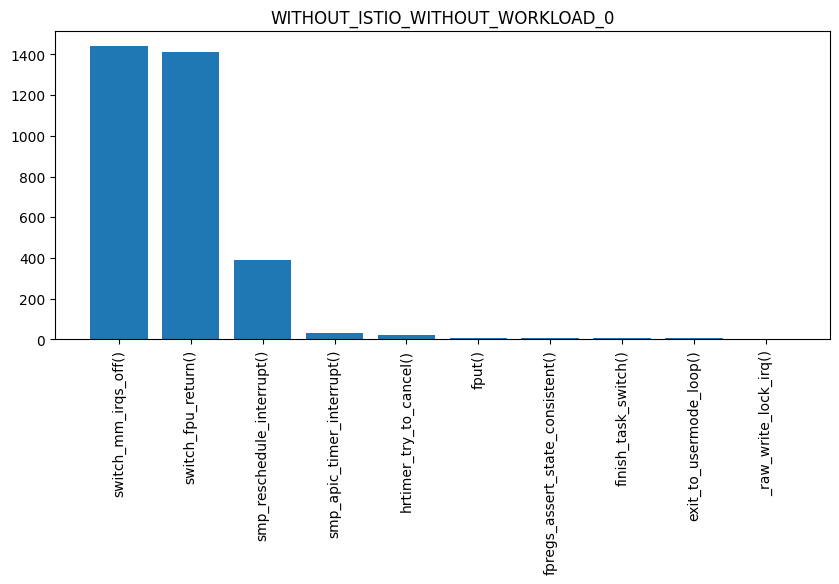

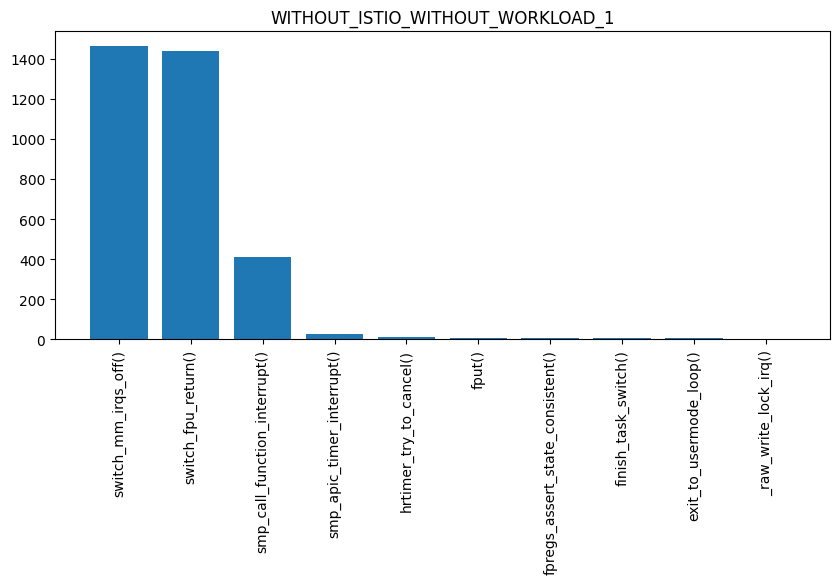

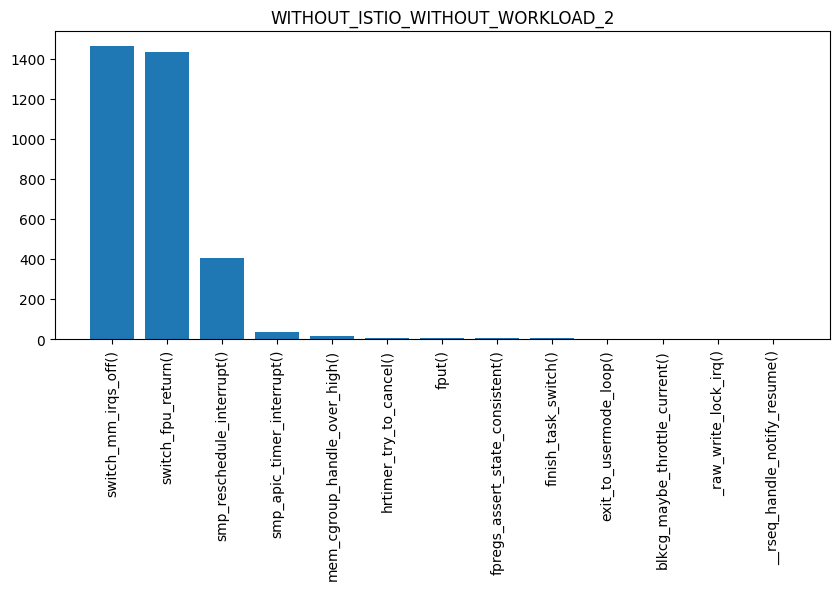

In [46]:
runs = get_runs()
for i in range(NUM_RUNS):
    count = get_function_counts(runs[i])
    plot_counts(count, title=f"{WORKLOAD}_{i}")

Points of Note
* switch_mm_irqs_off() is the most called function call consistenctly
* The function call counts are identical across the runs
* There are a total of only around 10-13 functions called in the idle runs at the top level of the callgraph

#### Parsing the callgraph recursively

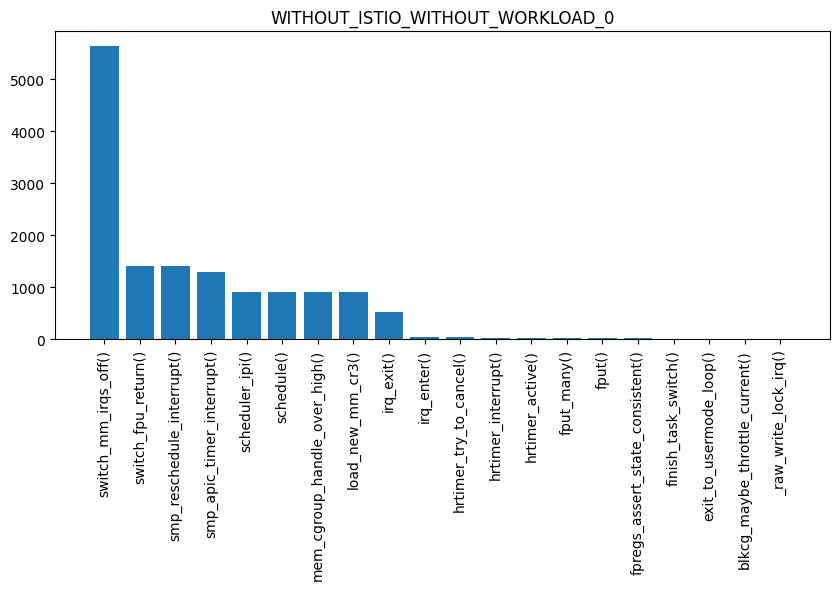

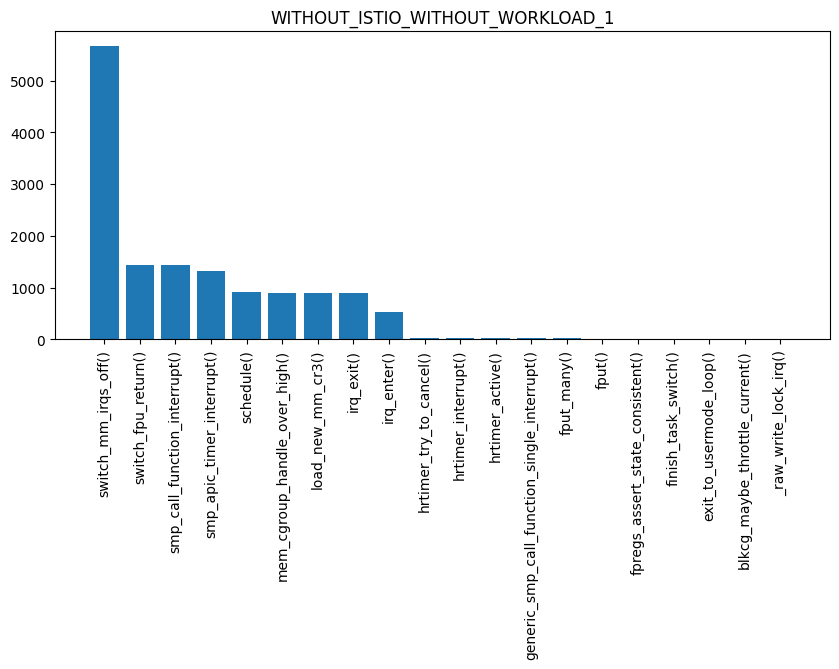

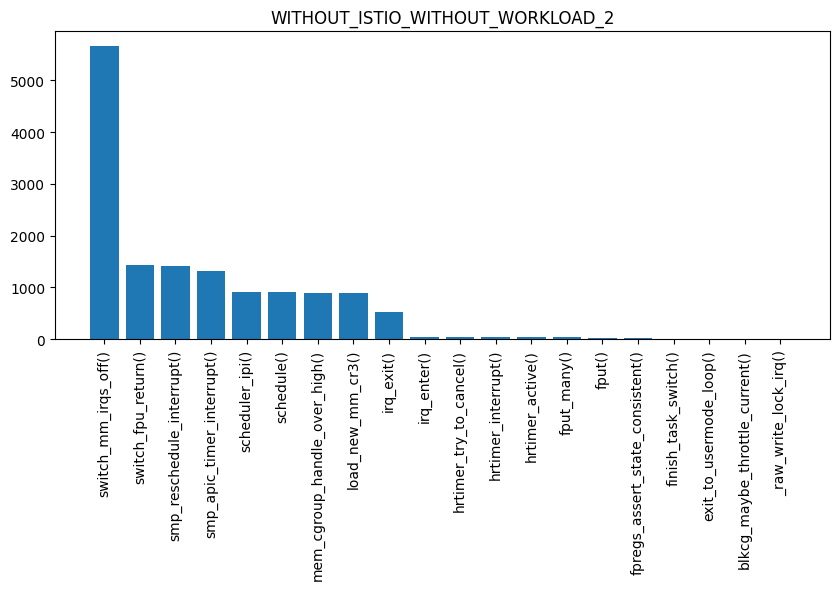

In [47]:
for i in range(NUM_RUNS):
    count = get_function_counts(runs[i], recurse=True)
    plot_counts(count, title=f"{WORKLOAD}_{i}")

In [51]:
function_counts = [get_function_counts(run, recurse=True) for run in runs]

with open(f"pickles/function_counts/{WORKLOAD}.pickle", "wb") as f:
    pickle.dump(function_counts, file=f)

In [52]:
print(len(function_counts[0]), len(function_counts[1]), len(function_counts[2]))

40 40 40


In [57]:
for i in range(NUM_RUNS):
    for j in range(NUM_RUNS):
        if i == j:
            continue

        print(f"Calls in {i} but not in {j} ", 
            set(function_counts[i].keys()).difference(set(function_counts[j].keys())), sep="\n", end="\n")
        print()

Calls in 0 but not in 1 
{'scheduler_ipi()', 'smp_reschedule_interrupt()'}

Calls in 0 but not in 2 
set()

Calls in 1 but not in 0 
{'smp_call_function_interrupt()', 'generic_smp_call_function_single_interrupt()'}

Calls in 1 but not in 2 
{'smp_call_function_interrupt()', 'generic_smp_call_function_single_interrupt()'}

Calls in 2 but not in 0 
set()

Calls in 2 but not in 1 
{'scheduler_ipi()', 'smp_reschedule_interrupt()'}



In [58]:
print(function_counts[1]["smp_call_function_interrupt()"], function_counts[1]["generic_smp_call_function_single_interrupt()"], sep=",")

(1, 1)

`{'smp_call_function_interrupt()',` and  `'generic_smp_call_function_single_interrupt()'}`
appears only in 1 out of the 3 runs. An the frequency of both functions is only once which is negligible

In [99]:

def get_count_diff(function_counts):
    count_diff = {}
    for i in range(NUM_RUNS):
        for j in range(NUM_RUNS):
            if i==j:
                continue
            count_diff[f"{i}-{j}"]= {}
            for function in function_counts[i].keys():
                lhs = function_counts[i].get(function, 0) 
                rhs = function_counts[j].get(function, 0)
                if lhs <= rhs: 
                    continue
                count_diff[f"{i}-{j}"][function] = (lhs - rhs) / lhs * 100
    return count_diff


In [100]:
diff_count = get_count_diff(function_counts=function_counts)

In [101]:
[(x, diff_count["0-1"][x]) for x in sorted(diff_count["0-1"], key=lambda x: diff_count["0-1"][x], reverse=True)]

[('smp_reschedule_interrupt()', 100.0),
 ('scheduler_ipi()', 100.0),
 ('schedule()', 66.66666666666666),
 ('load_new_mm_cr3()', 61.904761904761905),
 ('switch_mm_irqs_off()', 47.61904761904761),
 ('hrtimer_interrupt()', 19.35483870967742),
 ('irq_enter()', 16.129032258064516),
 ('irq_exit()', 16.129032258064516),
 ('finish_task_switch()', 12.5),
 ('hrtimer_try_to_cancel()', 12.5),
 ('hrtimer_active()', 12.5),
 ('_raw_write_lock_irq()', 12.5),
 ('fput()', 12.5),
 ('fput_many()', 12.5),
 ('smp_apic_timer_interrupt()', 12.121212121212121),
 ('__x64_sys_futex()', 6.0606060606060606)]

In [102]:
[(x, diff_count["0-2"][x]) for x in sorted(diff_count["0-2"], key=lambda x: diff_count["0-2"][x], reverse=True)]

[('smp_reschedule_interrupt()', 66.66666666666666),
 ('scheduler_ipi()', 66.66666666666666),
 ('load_new_mm_cr3()', 38.095238095238095),
 ('finish_task_switch()', 37.5),
 ('hrtimer_try_to_cancel()', 37.5),
 ('hrtimer_active()', 37.5),
 ('_raw_write_lock_irq()', 37.5),
 ('fput()', 37.5),
 ('fput_many()', 37.5),
 ('switch_mm_irqs_off()', 19.047619047619047)]

In [103]:
[(x, diff_count["1-0"][x]) for x in sorted(diff_count["1-0"], key=lambda x: diff_count["1-0"][x], reverse=True)]

[('smp_call_function_interrupt()', 100.0),
 ('generic_smp_call_function_single_interrupt()', 100.0),
 ('__x64_sys_epoll_wait()', 2.372644801116539),
 ('switch_fpu_return()', 2.1512838306731434),
 ('exit_to_usermode_loop()', 1.8982536066818527),
 ('fpregs_assert_state_consistent()', 0.4234297812279464)]

In [104]:
[(x, diff_count["2-0"][x]) for x in sorted(diff_count["2-0"], key=lambda x: diff_count["2-0"][x], reverse=True)]

[('mem_cgroup_handle_over_high()', 50.0),
 ('blkcg_maybe_throttle_current()', 50.0),
 ('__rseq_handle_notify_resume()', 50.0),
 ('irq_enter()', 11.428571428571429),
 ('hrtimer_interrupt()', 11.428571428571429),
 ('irq_exit()', 11.428571428571429),
 ('smp_apic_timer_interrupt()', 8.333333333333332),
 ('__x64_sys_futex()', 2.941176470588235),
 ('switch_fpu_return()', 1.4675052410901468),
 ('exit_to_usermode_loop()', 1.3740458015267176),
 ('__x64_sys_epoll_wait()', 1.2005649717514124),
 ('fpregs_assert_state_consistent()', 0.4234297812279464),
 ('__ia32_sys_getpid()', 0.1111111111111111),
 ('__x64_sys_openat()', 0.11098779134295228),
 ('__x64_sys_close()', 0.11074197120708748),
 ('__x64_sys_read()', 0.11013215859030838)]

In [105]:
[(x, diff_count["2-1"][x]) for x in sorted(diff_count["2-1"], key=lambda x: diff_count["2-1"][x], reverse=True)]

[('smp_reschedule_interrupt()', 100.0),
 ('scheduler_ipi()', 100.0),
 ('schedule()', 66.66666666666666),
 ('mem_cgroup_handle_over_high()', 50.0),
 ('blkcg_maybe_throttle_current()', 50.0),
 ('__rseq_handle_notify_resume()', 50.0),
 ('load_new_mm_cr3()', 38.46153846153847),
 ('switch_mm_irqs_off()', 35.294117647058826),
 ('hrtimer_interrupt()', 28.57142857142857),
 ('irq_enter()', 25.71428571428571),
 ('irq_exit()', 25.71428571428571),
 ('smp_apic_timer_interrupt()', 19.444444444444446),
 ('__x64_sys_futex()', 8.823529411764707),
 ('__ia32_sys_getpid()', 0.1111111111111111),
 ('__x64_sys_openat()', 0.11098779134295228),
 ('__x64_sys_close()', 0.11074197120708748),
 ('__x64_sys_read()', 0.11013215859030838)]

In [106]:
[(x, diff_count["1-2"][x]) for x in sorted(diff_count["1-2"], key=lambda x: diff_count["1-2"][x], reverse=True)]

[('smp_call_function_interrupt()', 100.0),
 ('generic_smp_call_function_single_interrupt()', 100.0),
 ('finish_task_switch()', 28.57142857142857),
 ('hrtimer_try_to_cancel()', 28.57142857142857),
 ('hrtimer_active()', 28.57142857142857),
 ('_raw_write_lock_irq()', 28.57142857142857),
 ('fput()', 28.57142857142857),
 ('fput_many()', 28.57142857142857),
 ('__x64_sys_epoll_wait()', 1.1863224005582695),
 ('switch_fpu_return()', 0.6939625260235947),
 ('exit_to_usermode_loop()', 0.5315110098709187)]

### Conclusion
* There is not a signifiicant difference between the counts of the various calls.
* Especially in without-istio-without-workload, most calls are seen very infrequently 
* The most frequent calls can be noted and assigned low weightage in future anlaysis